# MCA

**Author:** Florian Klaver

Objectives:
1. Load pre-processed rasters (Slope, Forest, Distances).
2. Normalize inputs to a common suitability scale (0.0 - 1.0).
3. Apply weights and calculate final Suitability Index.
4. Export and Visualize.

In [15]:
import os
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from pathlib import Path
from scipy.ndimage import uniform_filter, gaussian_filter

In [16]:
# --- CONFIGURATION ---
try:
    SCRIPT_DIR = Path(__file__).parent
except NameError:
    SCRIPT_DIR = Path.cwd()

PROJECT_ROOT = SCRIPT_DIR.parent
OUTPUT_DIR = PROJECT_ROOT / 'output'

# Input Files
PATHS = {
    "dem": OUTPUT_DIR / "dem_10m_graubuenden.tif",
    "slope": OUTPUT_DIR / "slope_10m_graubuenden.tif",
    "forest": OUTPUT_DIR / "forest_10m_graubuenden.tif",
    "dist_roads": OUTPUT_DIR / "distance_roads_10m.tif",
    "dist_settlements": OUTPUT_DIR / "distance_settlements_10m.tif",
    "water": OUTPUT_DIR / "water_mask_10m.tif",  # New from Preprocessing
    "prey": OUTPUT_DIR / "prey_10m.tif"          # New from Preprocessing
}

OUTPUT_FILE = OUTPUT_DIR / "habitat_suitability_final_wlc.tif"

# --- PARAMETERS ---
# Weights must sum to 1.0
WEIGHTS = {
    "forest": 0.25,     # Deckung
    "prey": 0.15,       # Nahrung (Alpweiden)
    "disturbance": 0.40, # Sicherheit (Strassen + Siedlung) - Dominant
    "elevation": 0.10,   # Bio-Limits
    "topography": 0.10   # Hangneigung
}

PARAMS = {
    "slope": {"max_ideal": 30, "cutoff": 50},
    "elevation": {"p_min": 500, "p_opt_min": 900, "p_opt_max": 2200, "p_max": 2600},
    
    # Sigmoids for Disturbance (Soft transitions)
    # Inflection: Distance where score is 0.5. Steepness: Contrast.
    "sec_roads": {"inflection": 500, "steepness": 0.005}, 
    "sec_settle": {"inflection": 1000, "steepness": 0.004},
    
    # Prey Smoothing (Gaussian Blur sigma in pixels)
    # 10px = 100m Radius smoothing to create "zones" from points
    "prey_sigma": 10 
}

In [17]:
# --- FUNCTIONS ---

def normalize_linear(array, min_val, max_val, inverse=False):
    arr_clipped = np.clip(array, min_val, max_val)
    norm = (arr_clipped - min_val) / (max_val - min_val)
    if inverse: return 1.0 - norm
    return norm

def calculate_sigmoid(array, inflection, steepness):
    return 1 / (1 + np.exp(-steepness * (array - inflection)))

def calculate_trapezoid(array, p_min, p_opt_min, p_opt_max, p_max):
    score = np.zeros_like(array, dtype=float)
    mask_up = (array > p_min) & (array < p_opt_min)
    score[mask_up] = (array[mask_up] - p_min) / (p_opt_min - p_min)
    score[(array >= p_opt_min) & (array <= p_opt_max)] = 1.0
    mask_down = (array > p_opt_max) & (array < p_max)
    score[mask_down] = (p_max - array[mask_down]) / (p_max - p_opt_max)
    return score

def read_raster(path):
    with rasterio.open(path) as src:
        return src.read(1), src.profile, src.nodata

## Main Analysis


--- 1. LOADING DATA ---
--- 2. CALCULATING SCORES ---
   -> Elevation & Slope...
   -> Forest Density...
   -> Prey Zones...
   -> Disturbance (Sigmoid)...
--- 3. WEIGHTED COMBINATION (WLC) ---
--- 4. EXPORTING ---
✅ Saved: c:\Workspace\ZHAW\5. Semester\GIS\project\output\habitat_suitability_final_wlc.tif
--- 5. PLOTTING WITH WATER OVERLAY ---


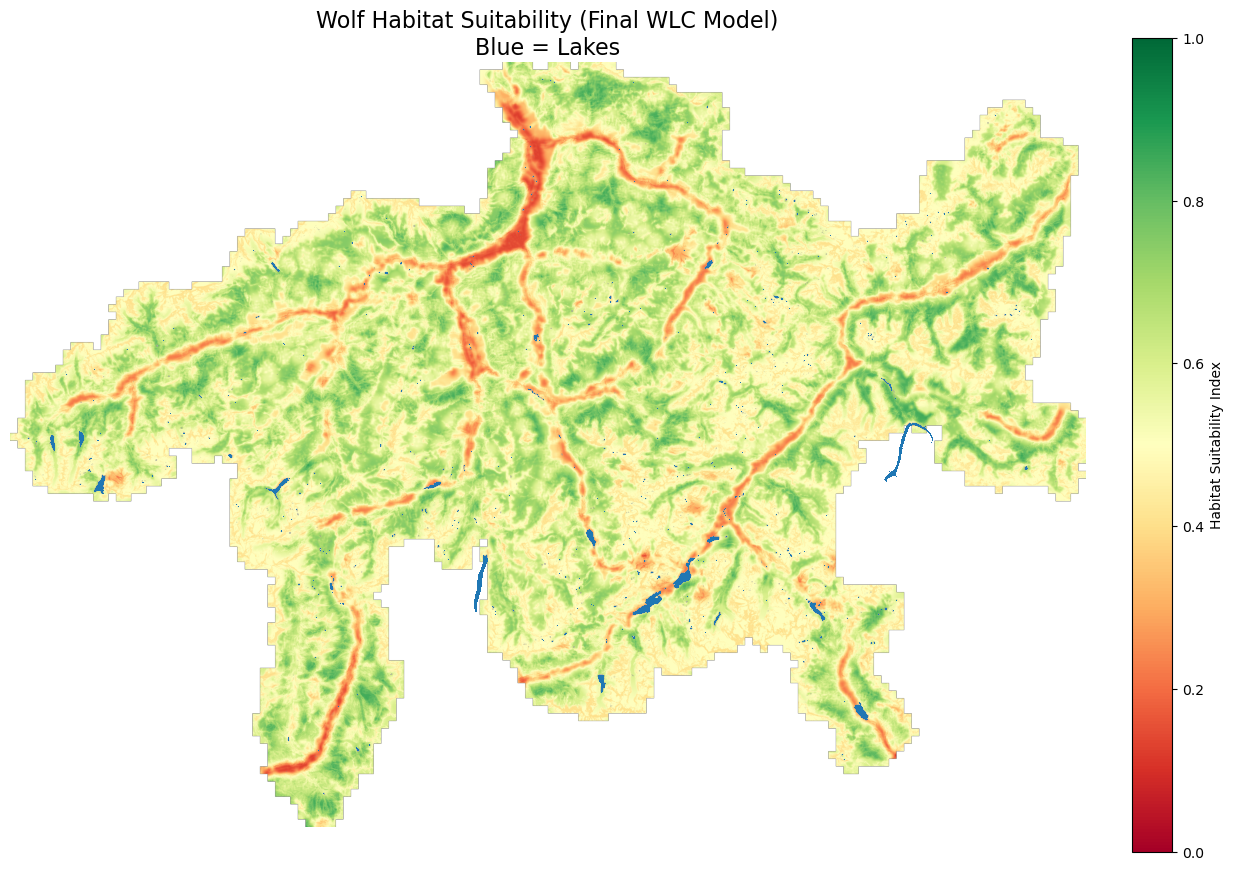

In [ ]:
print("\n--- 1. LOADING DATA ---")
dem, profile, nodata = read_raster(PATHS["dem"])
valid_mask = (dem != nodata)

slope, _, _ = read_raster(PATHS["slope"])
forest, _, _ = read_raster(PATHS["forest"])
dist_roads, _, _ = read_raster(PATHS["dist_roads"])
dist_settle, _, _ = read_raster(PATHS["dist_settlements"])
water, _, _ = read_raster(PATHS["water"])
prey, _, _ = read_raster(PATHS["prey"])

print("--- 2. CALCULATING SCORES ---")

# A. ECOLOGICAL
print("   -> Elevation & Slope...")
s_elev = calculate_trapezoid(dem, **PARAMS["elevation"])
s_slope = normalize_linear(slope, PARAMS["slope"]["max_ideal"], PARAMS["slope"]["cutoff"], inverse=True)
s_slope[slope <= PARAMS["slope"]["max_ideal"]] = 1.0

print("   -> Forest Density...")
# Density in 500m radius (50px)
s_forest = uniform_filter(forest.astype(float), size=50)

print("   -> Prey Zones...")
# Gaussian Blur to create hunting zones from sparse points
s_prey = gaussian_filter(prey.astype(float), sigma=PARAMS["prey_sigma"])
# Normalize to 0-1 (because blur lowers peak values)
if s_prey.max() > 0: s_prey = s_prey / s_prey.max()

# B. SECURITY (DISTURBANCE)
print("   -> Disturbance (Sigmoid)...")
s_roads = calculate_sigmoid(dist_roads, **PARAMS["sec_roads"])
s_settle = calculate_sigmoid(dist_settle, **PARAMS["sec_settle"])
# Average or Min? Average gives smoother maps. Min gives stricter maps.
# Let's use Average for WLC to avoid "Too Red" maps, but weighted heavily.
s_security = (s_roads + s_settle) / 2.0


print("--- 3. WEIGHTED COMBINATION (WLC) ---")
# Formula: Sum(Weight * Score)
final_hsi = (
    (s_forest * WEIGHTS["forest"]) +
    (s_prey * WEIGHTS["prey"]) +
    (s_elev * WEIGHTS["elevation"]) +
    (s_slope * WEIGHTS["topography"]) +
    (s_security * WEIGHTS["disturbance"])
)

# Mask Water (Set to -1 for special plotting handling, or NoData)
# We set water to NoData (-9999) for the analysis, but handle it in plotting
final_hsi[water == 1] = -9999 # Mask lakes in result
final_hsi[~valid_mask] = -9999 # Mask outside canton

# EXPORT
print("--- 4. EXPORTING ---")
profile.update(dtype=rasterio.float32, nodata=-9999, count=1)
with rasterio.open(OUTPUT_FILE, 'w', **profile) as dst:
    dst.write(final_hsi.astype(rasterio.float32), 1)
print(f"✅ Saved: {OUTPUT_FILE}")

# PLOTTING
print("--- 5. PLOTTING WITH WATER OVERLAY ---")
fig, ax = plt.subplots(figsize=(15, 12))

# 1. Plot Suitability (RdYlGn)
# Mask NoData values
plot_hsi = np.ma.masked_where(final_hsi == -9999, final_hsi)
im = ax.imshow(plot_hsi, cmap='RdYlGn', vmin=0, vmax=1)

# 2. Plot Water Overlay (Blue)
# Create a mask where Water == 1
water_overlay = np.ma.masked_where(water != 1, water)
# Plot simple blue color
ax.imshow(water_overlay, cmap=ListedColormap(['#1f77b4']), interpolation='none', alpha=1)

# Style
plt.colorbar(im, ax=ax, label="Habitat Suitability Index", fraction=0.035, pad=0.04)
ax.set_title("Wolf Habitat Suitability (Final WLC Model)\nBlue = Lakes", fontsize=16)
ax.axis('off')
plt.show()